In [22]:
import pandas as pd 
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
# read data with 
sites = ['site%d' %i for i in range(1,11)]
times = ['time%d' %i for i in range(1,11)]

train_df = pd.read_csv('train_sessions.csv', index_col='session_id', parse_dates=times)
test_df = pd.read_csv('test_sessions.csv', index_col='session_id', parse_dates=times)
pickle_file = 'site_dic.pkl'

In [3]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

## Data Cleaning First

In [4]:
# NaN values
train_df[sites] = train_df[sites].fillna(0)
train_df[sites] = train_df[sites].astype(int)
test_df[sites] = test_df[sites].fillna(0)
test_df[sites] = test_df[sites].astype(int)

train_df = train_df.sort_values(by='time1') # remove correlation with data order

### Since we know data frame combine with site# & time# 
### let's see ratio between target and non-target


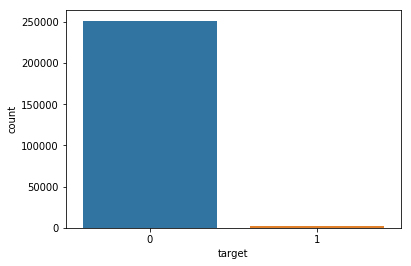

In [5]:
sns.countplot(train_df['target']) # this is a imbalance data

## start focusing on sites feature

In [6]:
# Let's see what is most freq website of Alice use
Alice_df = train_df[train_df['target']==1]
other_df = train_df[train_df['target']==0]
top_sites_alice = pd.Series(Alice_df[sites].values.flatten()).value_counts().drop(labels=[0]).sort_values(ascending=False).head(20)
top_sites_other = pd.Series(other_df[sites].values.flatten()).value_counts().drop(labels=[0]).sort_values(ascending=False).head(20)


In [7]:
# unique session
alice_unique_session = Alice_df[sites].apply(np.unique, axis=1).apply(len)

In [8]:
def uniq_count(x):
    uniq_array = np.unique(x)
    uniq_ct = len(uniq_array)
    if 0 in uniq_array:
        uniq_ct-=1
    return uniq_ct
alice_unique_session = Alice_df[sites].apply(uniq_count, axis=1)
other_unique_session = other_df[sites].apply(uniq_count, axis=1)



In [9]:
unique_session = train_df[sites].apply(uniq_count, axis=1) # without NaN sites
additional_feats = pd.DataFrame({'unique': unique_session})

In [10]:
additional_feats.head()

,unique
session_id,
21669,2
54843,2
77292,6
114021,5
146670,6


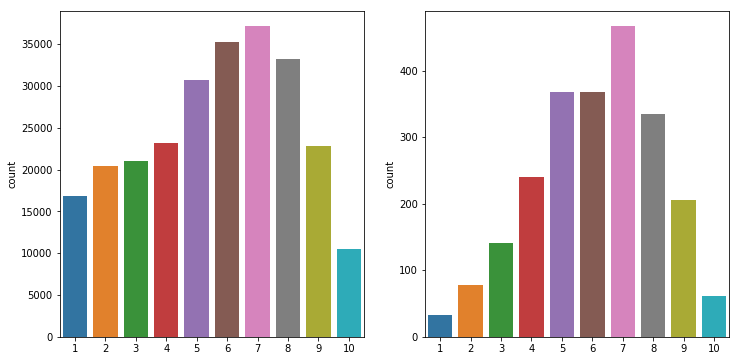

In [11]:
_, ax = plt.subplots(ncols=2, figsize=(12,6))
sns.countplot(other_unique_session, ax=ax[0])
sns.countplot(alice_unique_session, ax=ax[1])

In [12]:
alice_top20 = list(top_sites_alice.index)
alice_top20.sort()
other_top20 = list(top_sites_other.index)
other_top20.sort()

In [13]:
def have_top20_alice_sites(x, top20_sites):
    uniq_session = set(np.unique(x))
    have_top20_cnt = list(set(top20_sites) & uniq_session)
    return len(have_top20_cnt)
    
    

In [14]:
train_have_top20 = train_df[sites].apply(have_top20_alice_sites, top20_sites=alice_top20, axis=1)

In [15]:
additional_feats['have_top20#'] = train_have_top20 

In [16]:
additional_feats.head(5)

,unique,have_top20#
session_id,,
21669,2,0
54843,2,0
77292,6,0
114021,5,0
146670,6,0


## Start with time feature 

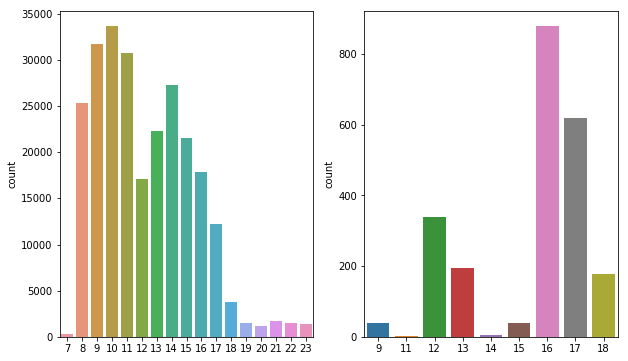

In [17]:
# Let's see website usage time distribution for different people
alice_session_start_time = Alice_df['time1'].apply(lambda ts: ts.hour).values
other_session_start_time = other_df['time1'].apply(lambda ts: ts.hour).values

_, ax = plt.subplots(ncols=2, figsize=(10,6))
sns.countplot(other_session_start_time, ax=ax[0])
sns.countplot(alice_session_start_time, ax=ax[1])
# compare with alice and other people most people start to search website around 10
# however alice usually start serach website at 12-13, and 16-18 looks like in lunch time or after working.
# at the work time she doesn't like using website.

                                 Alice main activities focus on 12-13 & 16-18

#### seperate start time at 4 zones

In [18]:
session_start_time = train_df['time1'].apply(lambda ts: ts.hour).values

morning = ((session_start_time>=7)&(session_start_time<=11)).astype('int')
day = ((session_start_time>=12)&(session_start_time<=18)).astype('int')
evening = ((session_start_time>=19)&(session_start_time<=23)).astype('int')
night = ((session_start_time>=0)&(session_start_time<=6)).astype('int')

In [33]:
additional_feats['morning'] = morning
additional_feats['day'] = day
additional_feats['evening'] = evening
additional_feats['night'] = night
additional_feats['start_hour'] = session_start_time

#### time duration of each session

In [42]:
durTime_train = (train_df[times].max(axis=1)-train_df[times].min(axis=1)).astype('timedelta64[s]').astype(int).values.reshape(-1,1)
durTime_test = (test_df[times].max(axis=1)-test_df[times].min(axis=1)).astype('timedelta64[s]').astype(int).values.reshape(-1,1)


## normalization
durTime_train_standard = scaler.fit_transform(durTime_train)
durTime_test_standard = scaler.transform(durTime_test)
additional_feats['duration'] = durTime_train_standard

C:\Users\13820\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\13820\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\13820\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#### Year/Month/weekday

In [23]:
## add Y/M/D 
scaler = StandardScaler()
train_weekday_feat = train_df[times]['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1,1)
train_yearmonth_feat = (train_df[times]['time1'].apply(lambda ts: ts.year*100+ts.month)/1e5).values.reshape(-1,1)
train_month_feat = train_df[times]['time1'].apply(lambda ts: ts.month).values.reshape(-1,1)

test_weekday_feat = test_df[times]['time1'].apply(lambda ts: ts.weekday()).values.reshape(-1,1)
test_yearmonth_feat = (test_df[times]['time1'].apply(lambda ts: ts.year*100+ts.month)/1e5).values.reshape(-1,1)
test_month_feat = test_df[times]['time1'].apply(lambda ts: ts.month).values.reshape(-1,1)

In [34]:
additional_feats['day_of_week'] = train_weekday_feat
additional_feats['yearmonth'] = train_yearmonth_feat
additional_feats['train_month_feat'] = train_month_feat

In [43]:
additional_feats.head()

,unique,have_top20#,morning,day,evening,night,start_hour,duration,day_of_week,yearmonth,train_month_feat
session_id,,,,,,,,,,,
21669,2,0,1,0,0,0,8,-0.468233,5,2.01301,1
54843,2,0,1,0,0,0,8,5.570015,5,2.01301,1
77292,6,0,1,0,0,0,8,-0.454709,5,2.01301,1
114021,5,0,1,0,0,0,8,-0.458090,5,2.01301,1
146670,6,0,1,0,0,0,8,-0.461471,5,2.01301,1


#### Let's see if alice popular site is different in work day or weekend

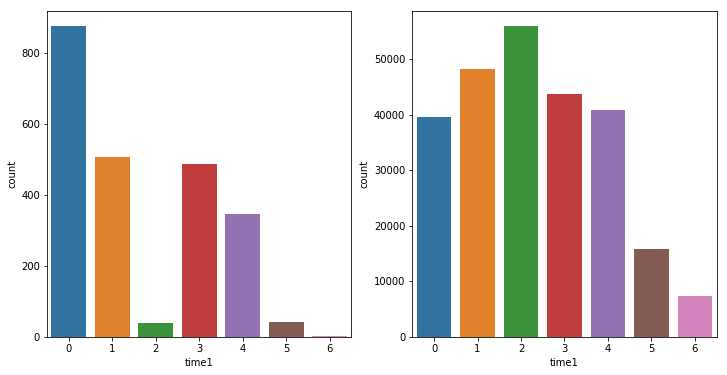

In [41]:
# use website freq vs. day of week
alice_weekday = train_df[train_df['target']==1]['time1'].apply(lambda ts: ts.weekday())
other_weekday = train_df[train_df['target']==0]['time1'].apply(lambda ts: ts.weekday())

_, ax = plt.subplots(ncols=2, figsize=(12, 6))
sns.countplot(alice_weekday, ax=ax[0])
sns.countplot(other_weekday, ax=ax[1])

Alice usually not use website frequently in wednesday & weekend, other people usually have a peak usage on wednesday 

In [56]:
## let's create features weekday(Tuesday) & and holiday
date_is_unactive_days = train_df['time1'].apply(lambda ts: ts.weekday()).isin([2,5,6]).map({True: 1, False: 0})

additional_feats['date_is_unactive_days'] = date_is_unactive_days

In [64]:
additional_feats.head()

,unique,have_top20#,morning,day,evening,night,start_hour,duration,day_of_week,yearmonth,train_month_feat,date_is_unactive_days
session_id,,,,,,,,,,,,
21669,2,0,1,0,0,0,8,-0.468233,5,2.01301,1,1
54843,2,0,1,0,0,0,8,5.570015,5,2.01301,1,1
77292,6,0,1,0,0,0,8,-0.454709,5,2.01301,1,1
114021,5,0,1,0,0,0,8,-0.458090,5,2.01301,1,1
146670,6,0,1,0,0,0,8,-0.461471,5,2.01301,1,1


#### Let's see what we have right now

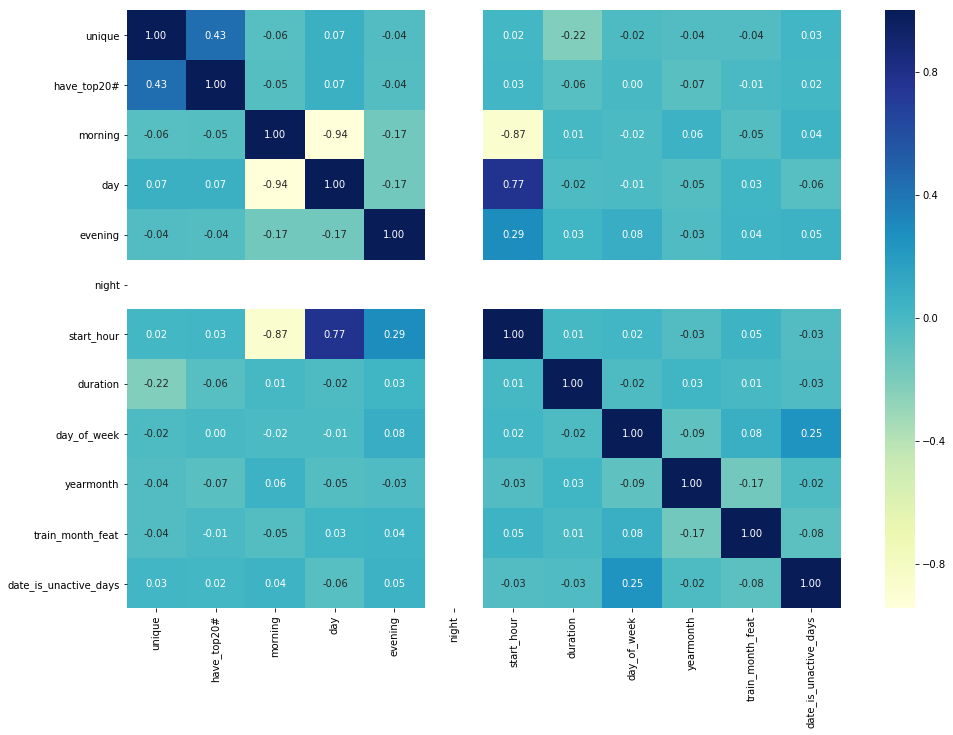

In [68]:
additional_feats_corr = additional_feats.corr('spearman')
plt.figure(figsize=(16, 11))
sns.heatmap(additional_feats_corr, annot=True, fmt='.2f',cmap='YlGnBu')

In [69]:
additional_feats

,unique,have_top20#,morning,day,evening,night,start_hour,duration,day_of_week,yearmonth,train_month_feat,date_is_unactive_days
session_id,,,,,,,,,,,,
21669,2,0,1,0,0,0,8,-0.468233,5,2.01301,1,1
54843,2,0,1,0,0,0,8,5.570015,5,2.01301,1,1
77292,6,0,1,0,0,0,8,-0.454709,5,2.01301,1,1
114021,5,0,1,0,0,0,8,-0.458090,5,2.01301,1,1
146670,6,0,1,0,0,0,8,-0.461471,5,2.01301,1,1
242171,5,0,1,0,0,0,8,-0.458090,5,2.01301,1,1
57157,5,0,1,0,0,0,8,-0.458090,5,2.01301,1,1
240201,6,0,1,0,0,0,8,-0.458090,5,2.01301,1,1
210686,5,0,1,0,0,0,8,-0.451328,5,2.01301,1,1
